In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import open3d as o3d
import pandas as pd
from scipy import spatial
from tqdm.auto import tqdm

from utils import config_rcparams, set_axes_equal, set_3d_params

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
config_rcparams()

In [3]:
%config InlineBackend.figure_format = 'retina'

# Extraction of the points on the boundary of the point cloud

Let’s assume we have a set of points, $\mathbb{X} = \{\mathbf{x}_1, \mathbf{x}_2, \dots, \mathbf{x}_n\}$, where $\mathbf{x}_i = (x_i, y_i, z_i)$ with $1 \leq i \leq n$, sampling a compact region $\Omega \subset \mathbb{R}^3$. We want to identify the subset of points that lie on the boundary surface $S = \partial \Omega$, called *surface points*.

<div style="text-align:center">
    <img style="margin:20px; width:450px;" src="figures/pc-surf.svg">
</div>

The following steps should be applied to each point, $\mathbf{x}_i$, in $\mathbb{X}$.

<div style="text-align:center">
    <img style="margin:20px; width:750px;" src="figures/pc-surf-extract.svg">
</div>

The following is the simple implementation in Python by using only the `SciPy.spatial` module.

In [4]:
def extract_surface_points(points, radius):
    """Return surface points on the point cloud.

    Parameters
    ----------
    points : numpy.ndarray
        Point cloud.
    radius : number
        The radius of points to create a local neighbourhood
        
    Return
    ------
    numpy.ndarray
        Surface points
    """
    surface_points = []
    tree = spatial.KDTree(points)
    for point in tqdm(points):
        # step 1: extract a local neighbourhood around the query point
        idx = tree.query_ball_point(point, r=radius, eps=0, p=2)
        nbh = points[idx]
    
        # step 2: estimate normal direction at the query point
        X = nbh.copy()
        X = X - np.mean(X, axis=0)
        C = X.T @ X
        U, S, _ = np.linalg.svd(C)
        n =  U[:, np.argmin(S)]
            
        # step 3: search two circular patches within neighbourhood
        centers = [point+n*radius/2,
                   point-n*radius/2]
        for center in centers:
            ii = tree.query_ball_point(center, r=radius/2, eps=0, p=2)
            if len(ii) in [0, 1]:
                surface_points.append(point)
    return np.unique(surface_points, axis=0)

Example:

In [5]:
# load the point cloud
fname = os.path.join('data', 'PSSACZ.ply')
pcd = o3d.io.read_point_cloud(fname)
points = np.asarray(pcd.points)

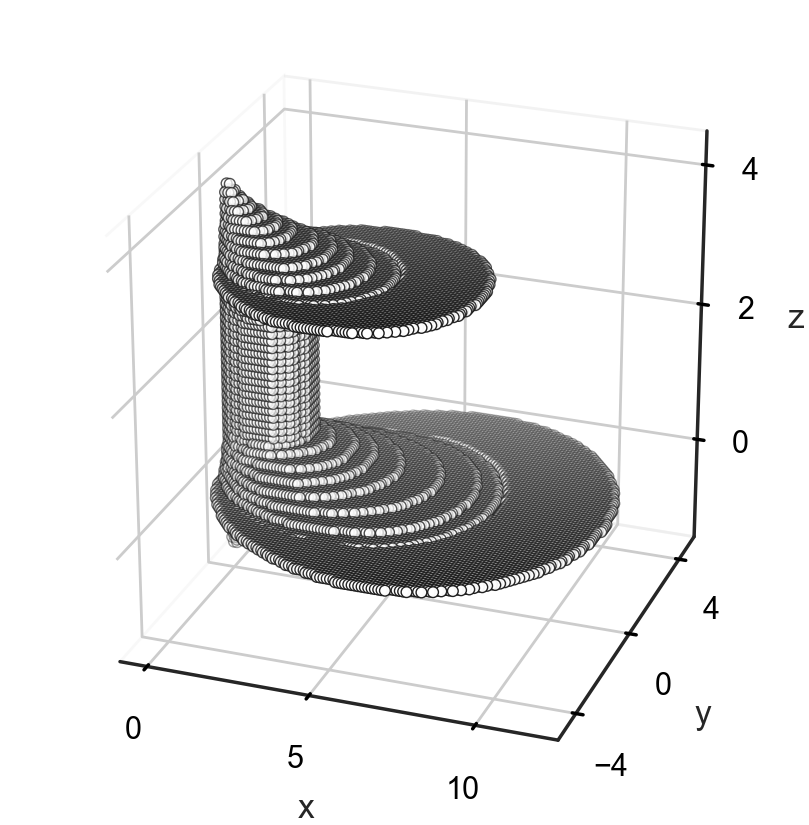

In [6]:
fig = plt.figure(figsize=(5, 5))
ax = plt.axes(projection='3d')
ax = set_3d_params(ax)
ax.scatter(*points.T, fc='w', ec='k', s=15, lw=0.5)
ax.view_init(25, -70);

In [7]:
# extract the surface
fname = os.path.join('data', 'PSSACZ_surf.ply')
if os.path.isfile(fname):
    pcd_surf = o3d.io.read_point_cloud(fname)
    surface_points = np.asarray(pcd_surf.points)
else:
    surface_points = extract_surface_points(points, radius=0.3)
    pcd_surf = o3d.geometry.PointCloud(
        o3d.utility.Vector3dVector(surface_points)
    )
    _ = o3d.io.write_point_cloud(fname, pcd_surf)

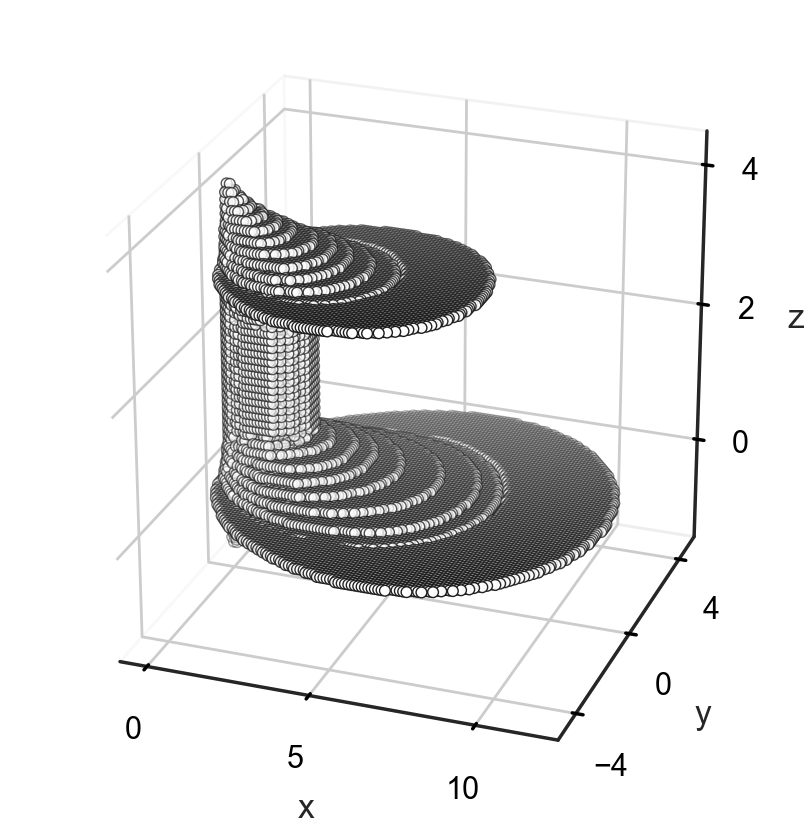

In [8]:
fig = plt.figure(figsize=(5, 5))
ax = plt.axes(projection='3d')
ax = set_3d_params(ax)
ax.scatter(*surface_points.T, fc='w', ec='k', s=15, lw=0.5)
ax.view_init(25, -70);